In [1]:
%load_ext autoreload
%autoreload 2

In [99]:
import geopandas as gpd
import pandas as pd 
import shapely
csv=pd.read_csv('../data/pools_refined.csv')
crs='EPSG:4326'
mrd_mining=gpd.GeoDataFrame(csv,geometry=gpd.points_from_xy(csv.x, csv.y), crs=crs)

union=mrd_mining.buffer(0.0007).unary_union
clusters=gpd.GeoDataFrame(geometry=[union], crs=crs)

clusters=clusters.explode()
clusters['count']=clusters.apply(lambda x: mrd_mining.within(x.geometry).sum(), axis=1)

clusters=clusters[clusters['count']>3]
clusters=clusters.centroid


buffered=mrd_mining.buffer(0.007)
exterior=buffered.total_bounds
aoi = shapely.box(
    exterior[0], exterior[1], exterior[2], exterior[3]
)
aoi_gdf=gpd.GeoDataFrame(geometry=[aoi], crs=crs)
aoi_gdf.crs='EPSG:4326'

sampled_points=aoi_gdf.sample_points(500).explode()
sampled_points=sampled_points[~sampled_points.intersects(buffered.unary_union)]

print('Number of positive samples:', len(clusters))
print('Number of negative samples:', len(sampled_points))
clusters.to_file('../data/sampling_locations/myanmar_positives.geojson',driver='GeoJSON')
sampled_points.to_file('../data/sampling_locations/myanmar_negatives.geojson',driver='GeoJSON')
clusters.explore()

/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_63794/3242551572.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  union=mrd_mining.buffer(0.0007).unary_union
/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_63794/3242551572.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  clusters=clusters.explode()
/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_63794/3242551572.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters=clusters.centroid
/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel

Number of positive samples: 188
Number of negative samples: 323


In [100]:
import geemap
import ee
center=mrd_mining.centroid[0].y, mrd_mining.centroid[0].x
nicfi = ee.ImageCollection('projects/planet-nicfi/assets/basemaps/asia')
nicfi=nicfi.filterDate('2024-01-01', '2024-12-31').median()
nicfi=nicfi.visualize(min=0, max=2000, bands=['R', 'G', 'B'])

Map = geemap.Map(center=center, zoom=10, add_google_map=False)
Map.addLayer(nicfi, {}, 'NICFI')

Map

/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_63794/1802530465.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center=mrd_mining.centroid[0].y, mrd_mining.centroid[0].x


Map(center=[25.67043612948806, 98.33349402], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [63]:
data_dir = '../data/sampling_locations/'
name='myanmar_river_negatives'
poly=geemap.ee_to_geojson(Map.draw_last_feature.geometry())
poly_gdf=gpd.GeoDataFrame(geometry=[shapely.geometry.shape(poly)], crs='EPSG:4326')
sample=poly_gdf.sample_points(500).explode()

with open(data_dir+name+'.geojson', 'w') as f:
    f.write(sample.to_json())   


/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_63794/1008925452.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sample=poly_gdf.sample_points(500).explode()


# Get Satellite Imagery

In [9]:
def unit_norm(pixels, sensor):

    means = [
    {'sensor': 'S1', 'means': [-10.051072817856399, -16.651867464319356], 'stds': [2.1963779145197058, 2.2873515832032276]},
    {'sensor': 'NICFI', 'means': [693.2319128158244, 591.905562019799, 370.506283013815, 2193.8863101174647], 'stds': [566.4167817564434, 407.356998077997, 301.56748366624953, 832.109348018454]},
    {'sensor': 'S2', 'means': [1047.0421641825503, 820.0529029070626, 736.9112470910904, 657.3229316729462, 917.6294938035609, 1601.7804385065751, 1862.7748065344267, 2070.6779779384606, 1900.2215942671394, 1106.512413656176, 1527.2338024527187, 846.5729582225177], 'stds': [138.43361906215526, 242.0529108661862, 324.7921000512644, 461.1909194988024, 462.2156960074404, 590.9384137703064, 684.0157226477746, 767.9100518105192, 764.794394500607, 312.25277975004417, 755.6635139128948, 519.84684613692]},
    {'sensor': 'Multi', 'means': [-10.051072817856399, -16.651867464319356, 1047.0421641825503, 820.0529029070626, 736.9112470910904, 657.3229316729462, 917.6294938035609, 1601.7804385065751, 1862.7748065344267, 2070.6779779384606, 1900.2215942671394, 1106.512413656176, 1527.2338024527187, 846.5729582225177],'stds': [2.1963779145197058, 2.2873515832032276, 138.43361906215526, 242.0529108661862, 324.7921000512644, 461.1909194988024, 462.2156960074404, 590.9384137703064, 684.0157226477746, 767.9100518105192, 764.794394500607, 312.25277975004417, 755.6635139128948, 519.84684613692]}
    ]
    norms = [m for m in means if m['sensor'] == sensor]
    means=norms[0]['means']
    deviations=norms[0]['stds']    

    # normalize each band to global unit norm
    for i in range(pixels.shape[2]):
        pixels[:, :, i] = (pixels[:, :, i] - means[i]) / deviations[i]

    return pixels

#pixels=[1,2,3,4,5]
unit_norm(pixels, 'Multi')

[{'sensor': 'Multi', 'means': [-10.051072817856399, -16.651867464319356, 1047.0421641825503, 820.0529029070626, 736.9112470910904, 657.3229316729462, 917.6294938035609, 1601.7804385065751, 1862.7748065344267, 2070.6779779384606, 1900.2215942671394, 1106.512413656176, 1527.2338024527187, 846.5729582225177], 'stds': [2.1963779145197058, 2.2873515832032276, 138.43361906215526, 242.0529108661862, 324.7921000512644, 461.1909194988024, 462.2156960074404, 590.9384137703064, 684.0157226477746, 767.9100518105192, 764.794394500607, 312.25277975004417, 755.6635139128948, 519.84684613692]}]


AttributeError: 'list' object has no attribute 'shape'

Creating training data for myanmar_positives with class 1
S2 10
188 tiles to download
Getting data from 2022-01-01 to 2022-03-01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Retrieved 188 patches
{'sensor': 'S2', 'means': [1047.0421641825503, 820.0529029070626, 736.9112470910904, 657.3229316729462, 917.6294938035609, 1601.7804385065751, 1862.7748065344267, 2070.6779779384606, 1900.2215942671394, 1106.512413656176, 1527.2338024527187, 846.5729582225177], 'stds': [138.43361906215526, 242.0529108661862, 324.7921000512644, 461.1909194988024, 462.2156960074404, 590.9384137703064, 684.0157226477746, 767.9100518105192, 764.794394500607, 312.25277975004417, 755.6635139128948, 519.84684613692]}


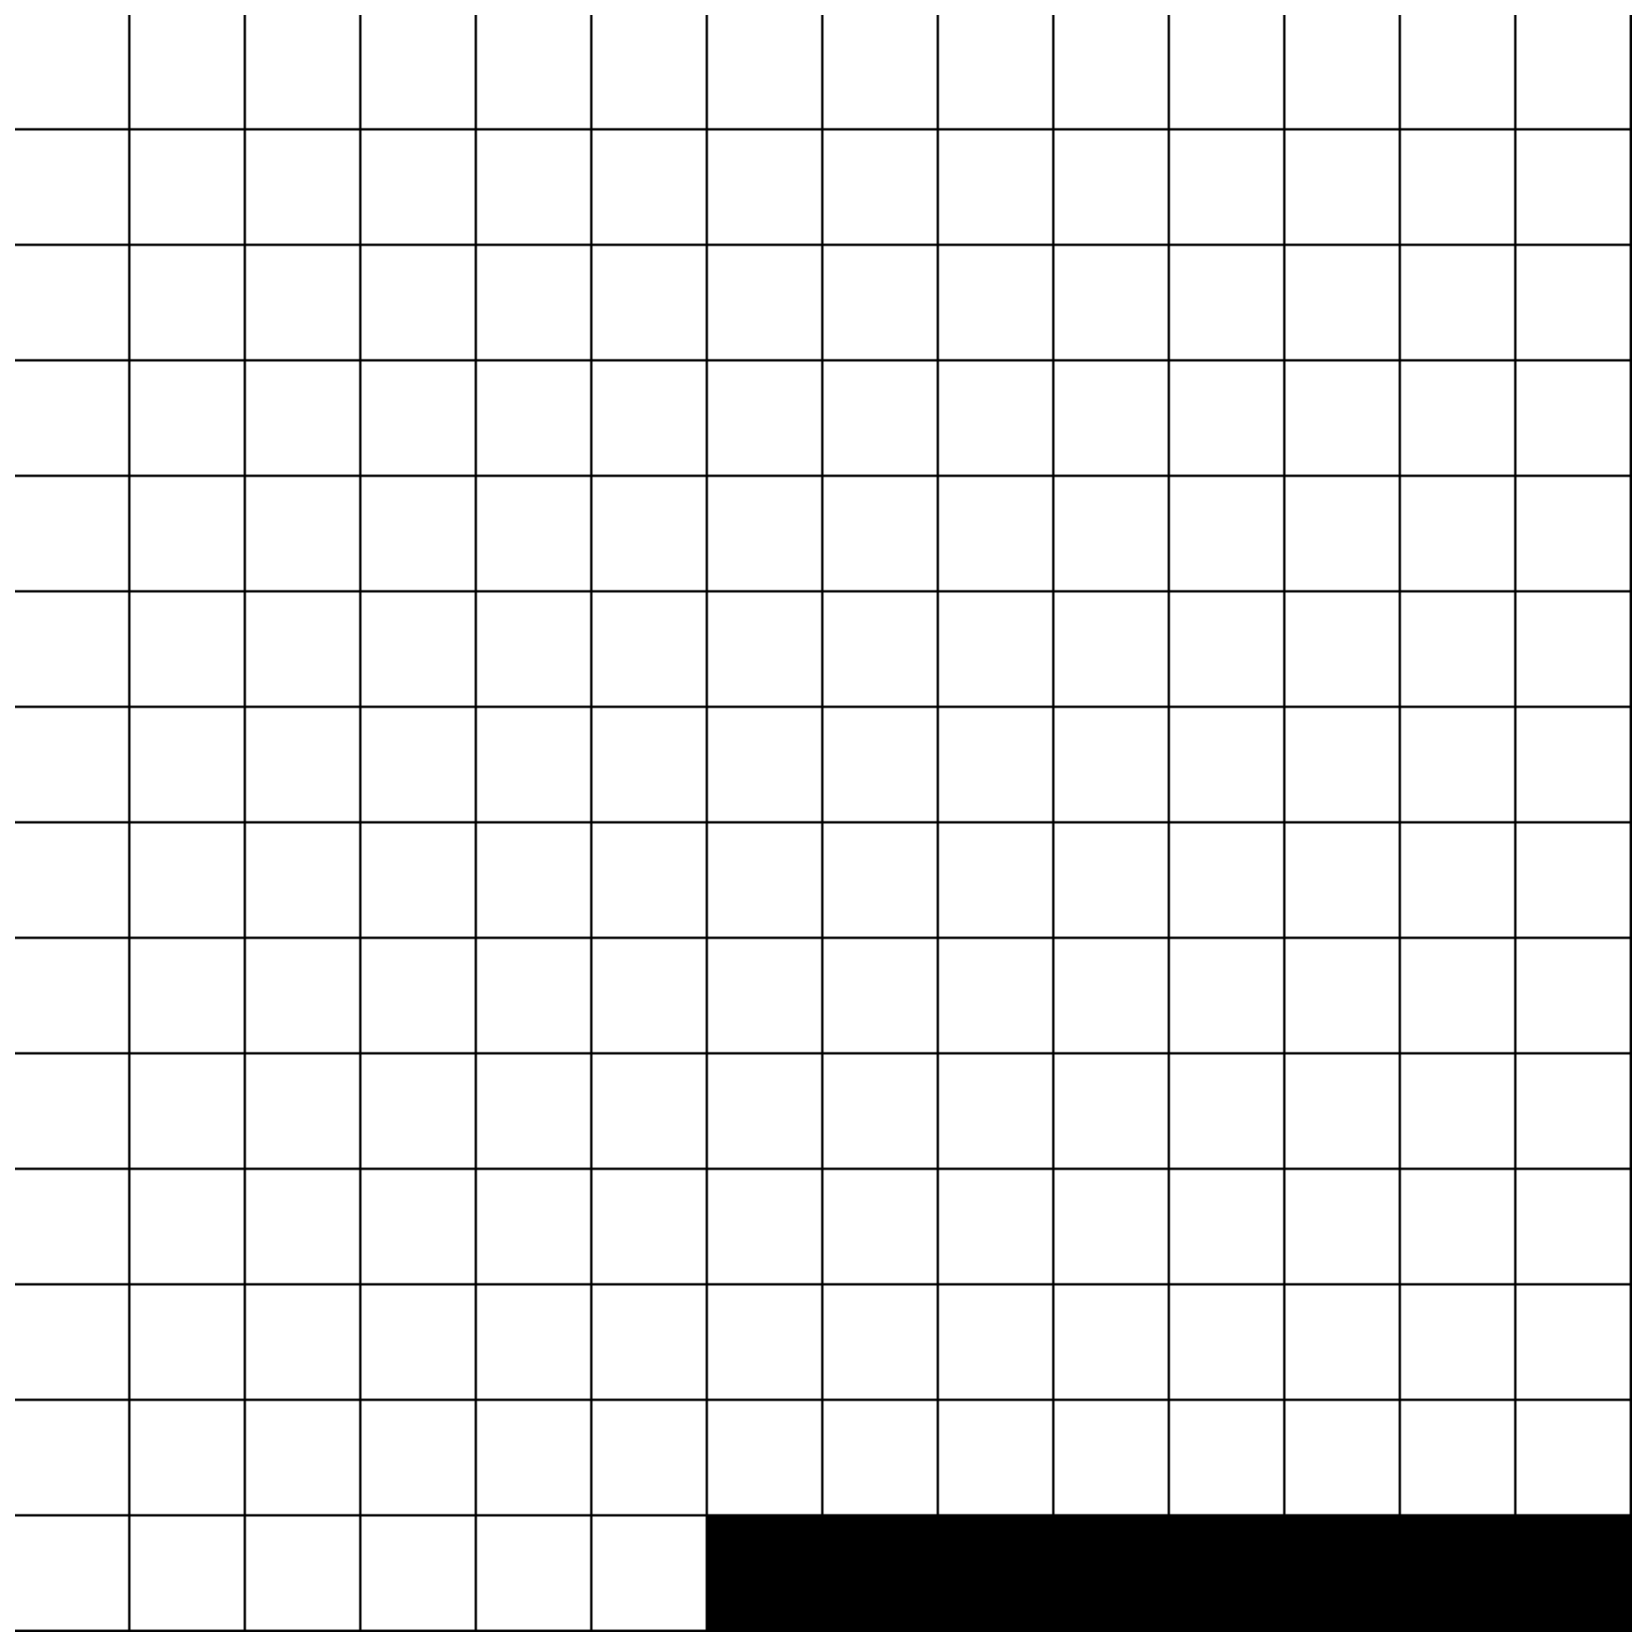

S2 10
188 tiles to download
Getting data from 2022-03-01 to 2022-05-01
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ollieballinger/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/v8/1pmfp2n52yg0xbnknpm7_7xh0000gn/T/ipykernel_11985/3794151749.py", line 55, in <module>
    training_data.get_patches()
  File "/Users/ollieballinger/Google Drive/Work/UCL/Research/Turing DSG/mining-detector/gee/get_training_data.py", line 128, in get_patches
    self.data, self.tiles = sensor_data.get_patches()
  File "/Users/ollieballinger/Google Drive/Work/UCL/Research/Turing DSG/mining-detector/gee/gee.py", line 224, in get_patches
    for future in concurrent.futures.as_completed(futures):
  File "/Users/ollieballinger/miniconda3/envs/geo/lib/python3.9/concurrent/futures/_base.py", line 245, in as_completed
    waiter.event.wait(wait_timeout)
  File "/Users/ollieballinger/miniconda3/envs/geo/lib/python3.9/threading.py", line 581, in wait


In [22]:
# load a file from sampling_locations
import get_training_data
import gee

#start_dates = ['2020-01-01', '2021-01-01', '2022-01-01']
#end_dates = ['2021-01-01', '2022-01-01', '2023-01-01']
start_dates = ['2022-01-01', '2022-03-01', '2022-11-01']
end_dates=['2022-03-01', '2022-05-01', '2023-01-01']

sensor='S2'

clear_threshold = 0.75  # minimum clear pixels for a tile to be included in the dataset

patch_size = 48
"""
data_files = ['bolivar_2020_thresh_0.8_1_negatives',
              'amazonas_2020_thresh_0.5_2_negatives',
              'riverbank_negatives',
              'amazonas_2020_thresh_0.8_sumbsample_3_positives',
              'MinesPos2018-2020Sentinel_points',
              'bolivar_2020_thresh_0.8_sumbsample_5_positives',
              'full_amazon_v9_negatives',
              'v2.0_bolivar_negatives',
              'v2.1.1_bolivar_negatives',
              'v2.4_amazonas_negatives',
              'v2.4_amazon_negatives',
              'v2.4_amazon_positives',
              'v2.6_amazon_thresh_0.8_negatives',
              'v2.6_amazon_negatives',
              'v2.6_amazon_negatives_v2'
              ]

data_file_labels = [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
"""
data_files = ['myanmar_positives', 'myanmar_negatives', 'myanmar_river_negatives']

data_file_labels = [1, 0, 0]

# create the training data
for sampling_file, label_class in zip(data_files, data_file_labels):
    print(f'Creating training data for {sampling_file} with class {label_class}')
    for start_date, end_date in zip(start_dates, end_dates):
        training_data = get_training_data.TrainingData(
            sampling_file,
            label_class,
            patch_size, 
            start_date, 
            end_date, 
            clear_threshold,
            batch_size=500,
            sensor=sensor,
            get_norms=True,
            )
        
        training_data.get_patches()


In [ ]:
#zip the training data
train_folder=f'../data/training_data/{sensor}_{patch_size}_px/'
filename=f'{sensor}_{patch_size}_px_training_data.zip'
#zip using filename
!zip -r $train_folder$filename $train_folder

!gsutil cp $train_folder$filename gs://qm2/$filename


  adding: ../data/training_data/NICFI_48_px/ (stored 0%)
  adding: ../data/training_data/NICFI_48_px/myanmar_positives_2022-11-01_2023-01-01.png (deflated 0%)
  adding: ../data/training_data/NICFI_48_px/myanmar_positives_2022-03-01_2022-05-01_patch_array_labels.pkl (deflated 95%)
  adding: ../data/training_data/NICFI_48_px/myanmar_negatives_2022-03-01_2022-05-01_patch_array_labels.pkl (deflated 97%)
  adding: ../data/training_data/NICFI_48_px/myanmar_positives_2022-01-01_2022-03-01_patch_array_labels.pkl (deflated 95%)
  adding: ../data/training_data/NICFI_48_px/myanmar_negatives_2022-03-01_2022-05-01.png (deflated 0%)
  adding: ../data/training_data/NICFI_48_px/myanmar_positives_2022-03-01_2022-05-01_patch_arrays.pkl (deflated 47%)
  adding: ../data/training_data/NICFI_48_px/myanmar_negatives_2022-01-01_2022-03-01.png (deflated 0%)
  adding: ../data/training_data/NICFI_48_px/myanmar_positives_2022-11-01_2023-01-01_patch_arrays.pkl (deflated 42%)
  adding: ../data/training_data/NICFI_4